In [1]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 18.6 ms, sys: 6.79 ms, total: 25.4 ms
Wall time: 1.22 s


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set3')

import IPython.display as display
from IPython.display import Video

from PIL import Image
import cv2

import torch

from ultralytics import YOLO

# Data analysis : construction safety - v2 release

In [3]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov9c' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = './css-data/'
    OUTPUT_DIR = './Output'

### Create Yaml file

In [4]:
dict_file = {
    'train': './train/images',
    'val': './valid/images',
    'test': './test/images',
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.CUSTOM_DATASET_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: ./test/images
train: ./train/images
val: ./valid/images



### Visualize many images

In [6]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

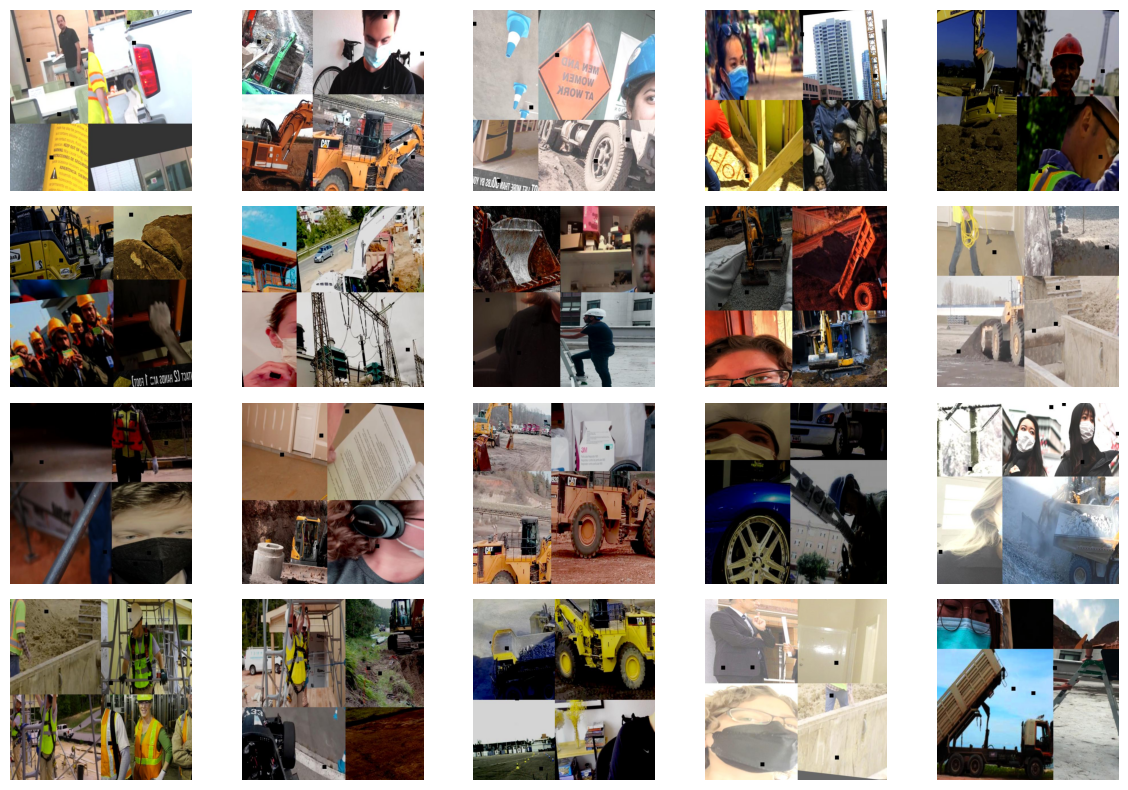

In [7]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [8]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


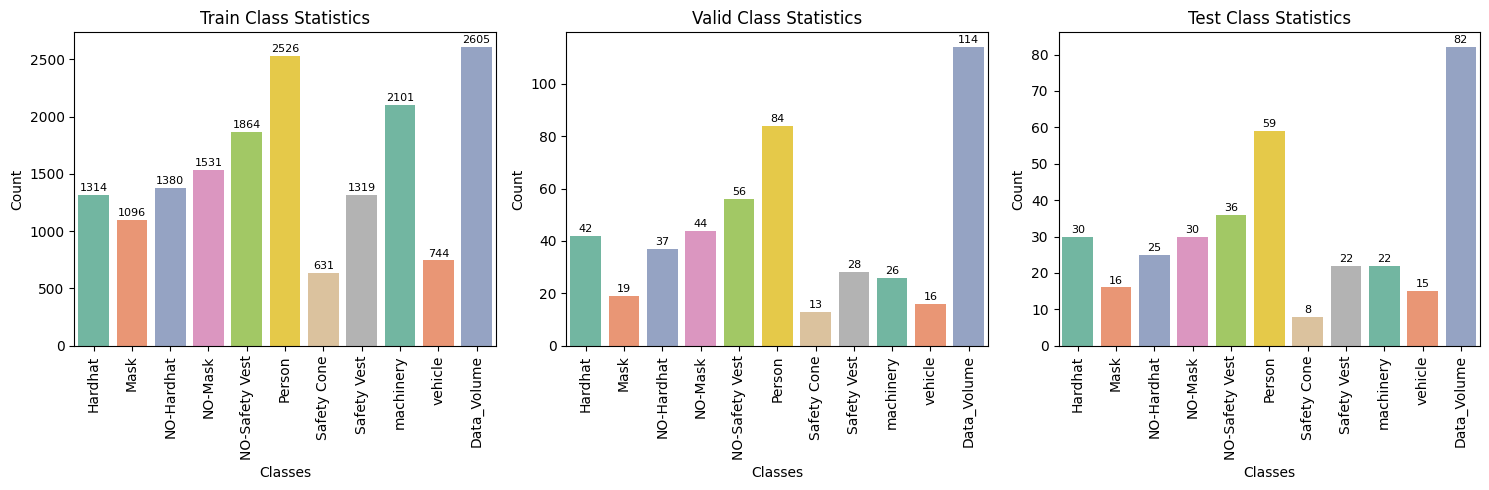

In [9]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### Train 

In [10]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 112M/112M [00:12<00:00, 9.66MB/s] 


In [11]:
img_properties = {'width': 640, 'height': 640, 'channels': 3}

In [12]:
%%time
### train
model.train(
    data = os.path.join(CFG.CUSTOM_DATASET_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    #device = [0,1], # 0
    verbose = False,
)

Ultralytics YOLOv8.1.28 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (13th Gen Intel Core(TM) i5-13600H)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=./css-data/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov9e_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /home/gabin/Bureau/Perso/Projets/Construction_safety/css-data/train/labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/gabin/Bureau/Perso/Projets/Construction_safety/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/gabin/Bureau/Perso/Projets/Construction_safety/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed



val: Scanning /home/gabin/Bureau/Perso/Projets/Construction_safety/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/163 [00:00<?, ?it/s]

: 